In [1]:
 !wget "https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv"

--2022-05-12 13:49:10--  https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv
Resolving web.stanford.edu (web.stanford.edu)... 171.67.215.200, 2607:f6d0:0:925a::ab43:d7c8
Connecting to web.stanford.edu (web.stanford.edu)|171.67.215.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44225 (43K) [text/csv]
Saving to: ‘titanic.csv’

titanic.csv         100%[===================>]  43.19K  --.-KB/s    in 0.1s    

2022-05-12 13:49:11 (300 KB/s) - ‘titanic.csv’ saved [44225/44225]



In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split

In [3]:
data = pd.read_csv("/content/titanic.csv")
data.head()

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500


In [4]:
data.drop(['Name'], axis = 1, inplace = True)

In [5]:
data.shape

(887, 7)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Survived                 887 non-null    int64  
 1   Pclass                   887 non-null    int64  
 2   Sex                      887 non-null    object 
 3   Age                      887 non-null    float64
 4   Siblings/Spouses Aboard  887 non-null    int64  
 5   Parents/Children Aboard  887 non-null    int64  
 6   Fare                     887 non-null    float64
dtypes: float64(2), int64(4), object(1)
memory usage: 48.6+ KB


In [7]:
data.describe()

,Survived,Pclass,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
count,887.000000,887.000000,887.000000,887.000000,887.000000,887.00000
mean,0.385569,2.305524,29.471443,0.525366,0.383315,32.30542
std,0.487004,0.836662,14.121908,1.104669,0.807466,49.78204
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.00000
25%,0.000000,2.000000,20.250000,0.000000,0.000000,7.92500
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.45420
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.13750
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.32920


In [8]:
dict(data.isnull().sum())

{'Age': 0,
 'Fare': 0,
 'Parents/Children Aboard': 0,
 'Pclass': 0,
 'Sex': 0,
 'Siblings/Spouses Aboard': 0,
 'Survived': 0}

In [9]:
data['Pclass'].value_counts()

3    487
1    216
2    184
Name: Pclass, dtype: int64

In [10]:
data['Sex'].value_counts()

male      573
female    314
Name: Sex, dtype: int64

In [11]:
data['Pclass'].dtype == np.int64

True

In [12]:
np.unique(data['Sex'])

array(['female', 'male'], dtype=object)

In [13]:
# LabelEncoder - 0, 1, 2,3,4,5,6
# O

In [14]:
def HandleNulls(data):
    null_dict = dict(data.isnull().sum())
    numerical_cols = [] # dtype -> int, float 
    categorical_cols = [] # dtype -> string, int, float (value counts < 15)
    for col, n_nulls in null_dict.items():
        # Identify if col is categoric or numeric 
        unique_values = np.unique(data[col])
        if len(unique_values) < 15:# consider as categoric 
            if n_nulls > 0:
                data[col].fillna(val = data[col].mode()[0], inplace = True)
        elif data[col].dtype in [np.float64, np.int64]:
            numerical_cols.append(col)
    
    # KNN impute numerical 
    Imputer = KNNImputer()
    data.loc[:, numerical_cols] = Imputer.fit_transform(data.loc[:, numerical_cols])
    return data

In [15]:
data = HandleNulls(data)

In [16]:
def ApplyOneHotEncoder(data, col):
    Ohe = OneHotEncoder(sparse = False)
    encodings = Ohe.fit_transform(data[[col]])[:, 1:]
    columns = [col + "_" +str(categorie) for categorie in Ohe.categories_[0][1:]] # Pclass_1,2,3
    encodings = pd.DataFrame(encodings, columns = columns, dtype = int)
    data = pd.concat([data, encodings], axis = 1)
    return data

def ApplyLabelEncoder(data, col):
    Le = LabelEncoder()
    data[col] = Le.fit_transform(data[col])
    return data

In [17]:
def HandleCategoricalCols(data, label_encoder = [], one_hot_encode = []):
    for col in label_encoder:
        data = ApplyLabelEncoder(data, col)
    for col in one_hot_encode:
        data = ApplyOneHotEncoder(data, col)
        data.drop([col], axis = 1, inplace = True)
    return data

In [18]:
data.head()

,Survived,Pclass,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,male,22.0,1,0,7.2500
1,1,1,female,38.0,1,0,71.2833
2,1,3,female,26.0,0,0,7.9250
3,1,1,female,35.0,1,0,53.1000
4,0,3,male,35.0,0,0,8.0500


In [19]:
data = HandleCategoricalCols(data, label_encoder = ['Sex'], one_hot_encode = ['Pclass'])

In [20]:
data.head()

,Survived,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,Pclass_2,Pclass_3
0,0,1,22.0,1,0,7.2500,0,1
1,1,0,38.0,1,0,71.2833,0,0
2,1,0,26.0,0,0,7.9250,0,1
3,1,0,35.0,1,0,53.1000,0,0
4,0,1,35.0,0,0,8.0500,0,1


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Survived                 887 non-null    int64  
 1   Sex                      887 non-null    int64  
 2   Age                      887 non-null    float64
 3   Siblings/Spouses Aboard  887 non-null    int64  
 4   Parents/Children Aboard  887 non-null    int64  
 5   Fare                     887 non-null    float64
 6   Pclass_2                 887 non-null    int64  
 7   Pclass_3                 887 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 55.6 KB


In [22]:
def DetectOutlier_Zscore(data, col):
    mean, std = data[col].mean(), data[col].std()
    high_threshold, low_threshold = mean + 3*std , mean - 3*std 
    higher_outliers, lower_outlier = data[col] > high_threshold, data[col] < low_threshold
    plt.plot(data[col])
    plt.plot([high_threshold]*data.shape[0])
    plt.plot([low_threshold]*data.shape[0])
    plt.show()
    return np.where(np.logical_or(higher_outliers, lower_outlier))[0], high_threshold, low_threshold

In [23]:
def HandleOutLiers(data, outlier_cols = []):
    for col in outlier_cols:
        print(col)
        idxs, _, _ = DetectOutlier_Zscore(data, col)
        data.loc[idxs, col] = np.nan

    Imputer = KNNImputer()
    data.loc[:, :] = Imputer.fit_transform(data) # return np.array
    return data

Age


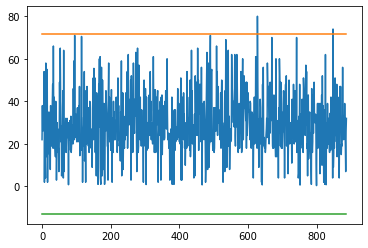

Fare


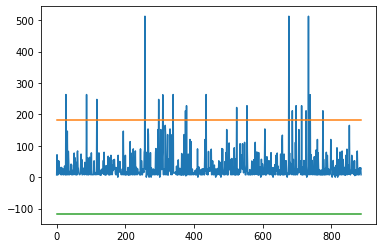

In [24]:
data = HandleOutLiers(data, outlier_cols = ['Age', 'Fare'])

In [25]:
def ScaleData(data, cols_to_scale = []):
    scaler = StandardScaler()
    data.loc[:, cols_to_scale] = scaler.fit_transform(data.loc[:, cols_to_scale])
    return data

In [26]:
data.head()

,Survived,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,Pclass_2,Pclass_3
0,0.0,1.0,22.0,1.0,0.0,7.2500,0.0,1.0
1,1.0,0.0,38.0,1.0,0.0,71.2833,0.0,0.0
2,1.0,0.0,26.0,0.0,0.0,7.9250,0.0,1.0
3,1.0,0.0,35.0,1.0,0.0,53.1000,0.0,0.0
4,0.0,1.0,35.0,0.0,0.0,8.0500,0.0,1.0


In [27]:
data = ScaleData(data,  cols_to_scale = ['Age', 'Fare'])

In [28]:
data.head()

,Survived,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,Pclass_2,Pclass_3
0,0.0,1.0,-0.528314,1.0,0.0,-0.673942,0.0,1.0
1,1.0,0.0,0.620046,1.0,0.0,1.513828,0.0,0.0
2,1.0,0.0,-0.241224,0.0,0.0,-0.650880,0.0,1.0
3,1.0,0.0,0.404728,1.0,0.0,0.892575,0.0,0.0
4,0.0,1.0,0.404728,0.0,0.0,-0.646609,0.0,1.0


In [29]:
Features = data.iloc[:, 1:].values
Target = data.iloc[:, 0].astype(int).values

In [30]:
Train_feat, Test_feat, Train_target, Test_target = train_test_split(Features, Target, test_size = 0.2, shuffle = True)

In [31]:
Train_feat.shape, Test_feat.shape

((709, 7), (178, 7))

ML

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(Train_feat, Train_target)

LogisticRegression()

In [33]:
model.score(Test_feat, Test_target)

0.7696629213483146